In [1]:
import os,sys,string, time
import ROOT
from math import *
from ROOT import gPad, TTree, TObject, TFile, gDirectory, TH1D, TH2D, TH3D, TCanvas, gROOT, TGaxis, gStyle, TColor, TLegend, THStack, TChain, TLatex, TText, TCollection, kRed, kBlue
from array import array
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from root_pandas import read_root
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
import xgboost
from xgboost import XGBClassifier
import joblib
import seaborn as sns
import pickle
from importlib import reload

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Functions as Functions

print ('Success')


Welcome to JupyROOT 6.24/06
Success


In [2]:
Params = {"Run":"run3", #The run number, so far either "run1" or "run3"
          "Load_single_file":False, #This will override everything else, put the desired file in the "single_file" line
          "single_file":10,
          "Load_standard":False, #bkgs
          "Load_lepton_signal":False,
          "Load_pi0_signal":False,
          "Load_DetVars":True, #This is for overlay
          "Only_keep_common_DetVar_evs":True,
          "Load_Signal_DetVars":False, #Don't do here, but in seperate script
          "Load_data":False,
          "FLATTEN":True, #Have one row per reconstructed object in the analysis dataframe
          "only_presel":False, #Create small files containing only variables necessary for pre-selection, for making pre-selection plots
          "EXT_in_training":False,
          "Use_logit":True,
          "nbins":5} 

feature_names = Variables.First_pass_vars_for_BDT #All variables
feature_names_MC = feature_names + ["weight"]
loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/my_vars/"

samples = Functions.create_test_samples_list(Params)

if Params["Load_pi0_signal"] == True:
    pi0_sample_strings = [] #Unfortunately need to make, to discriminate lepton final states from pi0 final states for signal
    for pi0_point in Constants.HNL_mass_pi0_samples:
        pi0_sample_strings += [str(pi0_point)+"_pi0"]
        

Loading these run3 samples: 
['WireModX', 'WireModYZ', 'WireModThetaXZ', 'WireModThetaYZ', 'WireModdEdX', 'LYDown', 'LYRayleigh', 'LYAttenuation', 'SCE', 'Recomb2', 'CV']


In [3]:
sample_test_dict = {}
for sample in samples:
    if sample in Constants.Detector_variations: #Reading in an overlay DetVar sample
        loc=loc_pkls+"DetVars/"+"Preselected_overlay_"+Params["Run"]+"_my_vars"+f"_{sample}_flattened_reduced_evs.pkl"
        sample_test_dict[sample] = pd.read_pickle(loc)
    elif Params["Load_Signal_DetVars"] == True:
        loc=loc_pkls+"Signal_DetVars/"+"Preselected_"+Params["Run"]+f"_{sample}_reduced_evs.pkl"
        sample_test_dict[sample] = pd.read_pickle(loc)
    #elif sample in Constants.Signal_DetVars: #For signal DetVar samples, now doing in another script
    elif Params["Load_pi0_signal"] == True:
        if sample == 'overlay':
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+"BDT_Test_dfs/pi0_selection/Test_overlay_"+Params["Run"]+".pkl")
        elif sample in pi0_sample_strings:
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"BDT_Test_dfs/pi0_selection/Test_signal_{sample}_"+Params["Run"]+".pkl")
        elif (sample == 'beamoff') and (Params["EXT_in_training"] == True): #EXT only if extra EXT has been added
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+"BDT_Test_dfs/pi0_selection/Test_beamoff_"+Params["Run"]+".pkl")
        else: 
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"pi0_selection/Preselected_"+Params["Run"]+f"_{sample}.pkl")
    else: #Standard sample types
        if sample == 'overlay':
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+"BDT_Test_dfs/Test_overlay_"+Params["Run"]+"_my_vars_flattened.pkl")
        elif (Params["Load_single_file"] == True) and (isinstance(sample,int)):
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"BDT_Test_dfs/Test_signal_{sample}_"+Params["Run"]+"_my_vars_flattened.pkl")
        elif sample in Constants.HNL_mass_samples:
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"BDT_Test_dfs/Test_signal_{sample}_"+Params["Run"]+"_my_vars_flattened_New_gen.pkl")
        elif (sample == 'beamoff') and (Params["EXT_in_training"] == True): #EXT only if extra EXT has been added
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+"BDT_Test_dfs/Test_beamoff_"+Params["Run"]+"_my_vars_flattened.pkl")
        else: 
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"Preselected_{sample}_"+Params["Run"]+"_my_vars_flattened_New_gen.pkl")


In [4]:
New_feature_list = ['shrclusdir2', 'n_tracks', 'trk_energy', 'shr_theta_v', 'contained_sps_ratio', 'trk_chipr_best', 'shr_px_v',
                    'trk_end_x_v', 'n_pfps', 'pfnplanehits_V', 'pfnplanehits_U', 'trk_calo_energy_u_v', 'nu_flashmatch_score', 'trk_score_v',
                    'NeutrinoEnergy2', 'shr_phi_v', 'pfnplanehits_Y', 'shr_pz_v', 'trk_theta_v', 'trk_phi_v', 'trk_energy_hits_tot',
                    'trk_dir_z_v', 'SliceCaloEnergy2']

# bdt_vars = feature_names
bdt_vars = New_feature_list
xgb_test_dict = {}
for sample in sample_test_dict:
    xgb_test_dict[sample] = xgboost.DMatrix(sample_test_dict[sample][bdt_vars])
    # print("Done " + str(sample))
    
if Params["Load_single_file"] == True:
    HNL_mass = Params["single_file"]
    bdt = xgboost.Booster()
    bdt.load_model(f"bdts/"+Params["Run"]+f"_{HNL_mass}_MeV_My_variables.json")
    for sample in xgb_test_dict:
        results = bdt.predict(xgb_test_dict[sample])
        sample_test_dict[sample][f"BDT_output_{HNL_mass}MeV"] = results
    
elif Params["Load_pi0_signal"] == False:
    for HNL_mass in Constants.HNL_mass_samples:
        bdt = xgboost.Booster()
        # bdt.load_model(f"bdts/"+Params["Run"]+f"_{HNL_mass}_MeV_My_variables_flattened_highest_E_1.json")
        bdt.load_model("bdts/"+Params["Run"]+f"_{HNL_mass}_MeV_New_20_variables.json")
        for sample in xgb_test_dict:
            results = bdt.predict(xgb_test_dict[sample])
            sample_test_dict[sample][f"BDT_output_{HNL_mass}MeV"] = results
            
if Params["Load_pi0_signal"] == True:
    for HNL_mass in Constants.HNL_mass_pi0_samples:
        bdt = xgboost.Booster()
        bdt.load_model(f"bdts/pi0_selection/"+Params["Run"]+f"_{HNL_mass}_MeV_pi0.json")
        for sample in xgb_test_dict:
            results = bdt.predict(xgb_test_dict[sample])
            sample_test_dict[sample][f"BDT_output_{HNL_mass}MeV"] = results

In [5]:
def Save_one_hist(hist,name,nbins,xlims):
    # tData = ROOT.TH1F(name,name,nbins,xlims[0],xlims[1])
    tData = ROOT.TH1F(name,name,len(nbins)-1,array("d",nbins))
    for i in range(len(nbins)-1):
        tData.SetBinContent(i+1,hist['hist'][i])
        tData.SetBinError(i+1,hist['err'][i])
    return tData
    
def SaveToRoot_new(nbins,xlims,hist_samples,fileName='test.root'): 
    rFile = ROOT.TFile(f'bdt_output/{fileName}','RECREATE')
    for name in hist_samples:
        tData = Save_one_hist(hist_samples[name],name,nbins,xlims)
        rFile.Write()
    #rFile.Write()
    rFile.Close()

def make_stat_err(hist, SF):
    stat_err = []
    for i in range(0,len(hist[0])):
        error = np.sqrt(hist[0][i])*np.sqrt(SF)
        stat_err.append(error)
    return stat_err

In [6]:
def safe_div(x,y):
    if y == 0.0:
        return 0
    return x / y

def Calc_RMS_quadsum(CV_hist, dict_detvar_hists): #Currently assuming "mean" value to be the CV, I believe this is the correct thing to do
    nbins = len(CV_hist)
    RMS_on_bins = np.zeros(nbins)
    Quad_sum_on_bins = np.zeros(nbins)
    RMS_on_bins_frac = np.zeros(nbins)
    Quad_sum_on_bins_frac = np.zeros(nbins)
    num_samples = len(dict_detvar_hists) #This should NOT include the CV hist
    for j in range(nbins): #Looping over bins
        sum_diffs_squared = 0
        for detvar in dict_detvar_hists:
            diff = dict_detvar_hists[detvar][j]-CV_hist[j] #Difference between the number in the CV sample and the DetVar sample
            sum_diffs_squared += diff**2
        variance = sum_diffs_squared/num_samples
        RMS_on_bins[j] = np.sqrt(variance) #The total RMS error on the bin
        Quad_sum_on_bins[j] = np.sqrt(sum_diffs_squared)
        RMS_on_bins_frac[j] = safe_div(np.sqrt(variance),CV_hist[j]) #Need to calculate here to avoid problems with zero divisor
        Quad_sum_on_bins_frac[j] = safe_div(np.sqrt(sum_diffs_squared),CV_hist[j])
              
    return {"RMS":RMS_on_bins, "quadsum":Quad_sum_on_bins, "RMS_frac":RMS_on_bins_frac, "quadsum_frac":Quad_sum_on_bins_frac}

def Calc_frac_diff(CV_hist, dict_detvar_hists):
    nbins = len(CV_hist)
    frac_diff_dict = {}
    perc_diff_dict = {}
    for detvar in dict_detvar_hists: #Should NOT contain CV hist
        frac_diff_on_bins = np.zeros(nbins)
        perc_diff_on_bins = np.zeros(nbins)
        for j in range(nbins): #Looping over bins
            frac = safe_div(dict_detvar_hists[detvar][j],CV_hist[j])
            frac_diff = frac - 1.0
            perc_diff = (frac_diff*100)
            frac_diff_on_bins[j] = frac_diff
            perc_diff_on_bins[j] = perc_diff
        frac_diff_dict[detvar] = frac_diff_on_bins
        perc_diff_dict[detvar] = perc_diff_on_bins
           
    return frac_diff_dict, perc_diff_dict

def Calc_stat_err(CV_hist, CV_hist_unweighted): #Calculate the statistical (Poisson) error on each bin for the central value histogram
    nbins = len(CV_hist)
    stat_err_on_bins = np.zeros(nbins)
    for j in range(nbins): #Looping over bins
        poisson_err = np.sqrt(CV_hist_unweighted[j])
        SF = CV_hist_unweighted[j]/CV_hist[j] #The factor this bin is scaled by due to weighting
        stat_err_on_bins[j] = poisson_err*SF #Need to scale the Poisson error by whatever the total scaling on the bin is
    return stat_err_on_bins

## Plotting overlay Detector variations

In [7]:
bins_dict = {}
for HNL_mass in Constants.HNL_mass_samples:
    hist_placeholder = uproot.open(f'bdt_output/'+Params["Run"]+f'_{HNL_mass}MeV_logit_top_20_merged_FIXED.root')
    bins_dict[HNL_mass] = hist_placeholder['bkg_overlay'].to_numpy()[1] #A tuple of bin edges
print("Loaded bins for " + str(bins_dict.keys()))

# print(bins_dict[240])

#re-binning! to try and deal with the run1 detvars giving large errrors
# for HNL_mass in Constants.HNL_mass_samples:
#     if HNL_mass in [220,240]:
#         bins_dict[HNL_mass] = np.array([-5, -4, -3, -2, -1,  0,  1,  2,  5])
#     else:
#         bins_dict[HNL_mass] = np.array([-5, -4, -3, -2, -1,  0,  1,  2, 3,  5])


Loaded bins for dict_keys([2, 10, 20, 50, 100, 150, 180, 200, 220, 240, 245])


Plotting 2MeV histogram
Plotting 10MeV histogram
Plotting 20MeV histogram
Plotting 50MeV histogram
Plotting 100MeV histogram
Plotting 150MeV histogram
Plotting 180MeV histogram
Plotting 200MeV histogram
Plotting 220MeV histogram
Plotting 240MeV histogram
Plotting 245MeV histogram


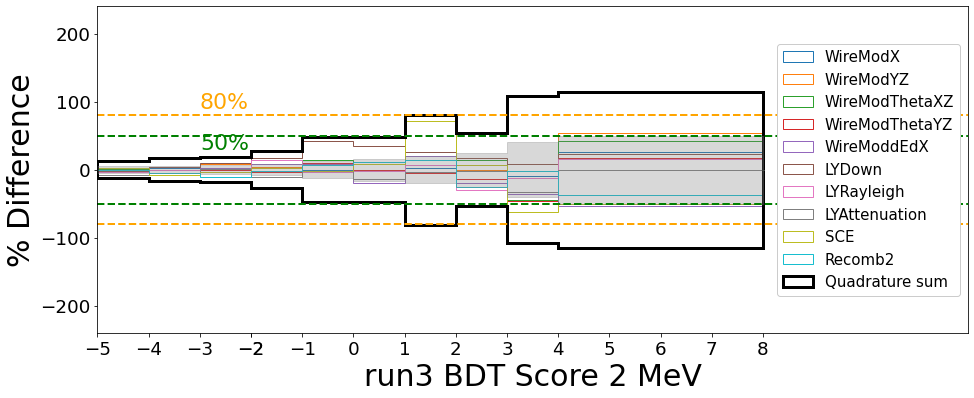

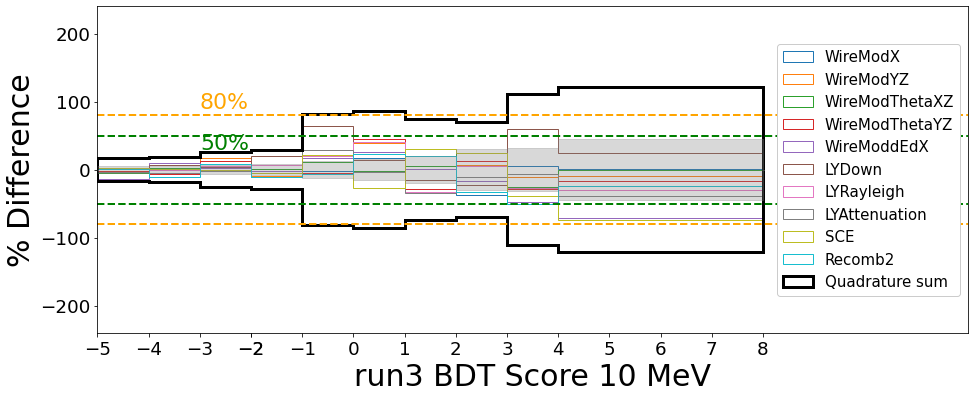

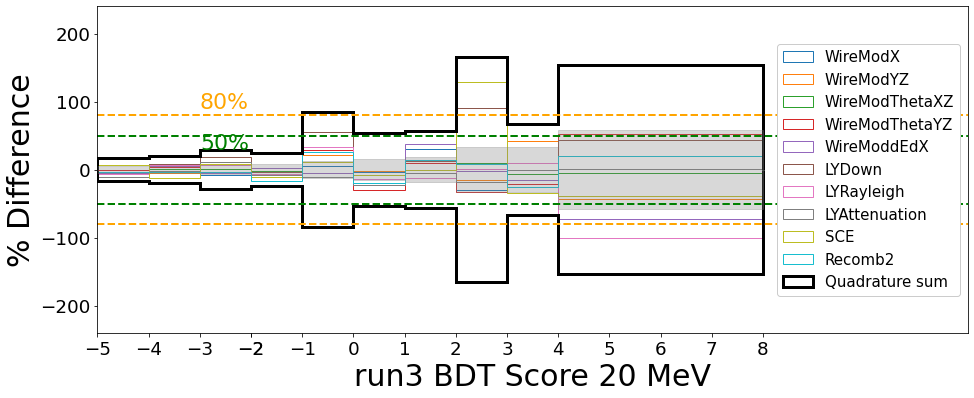

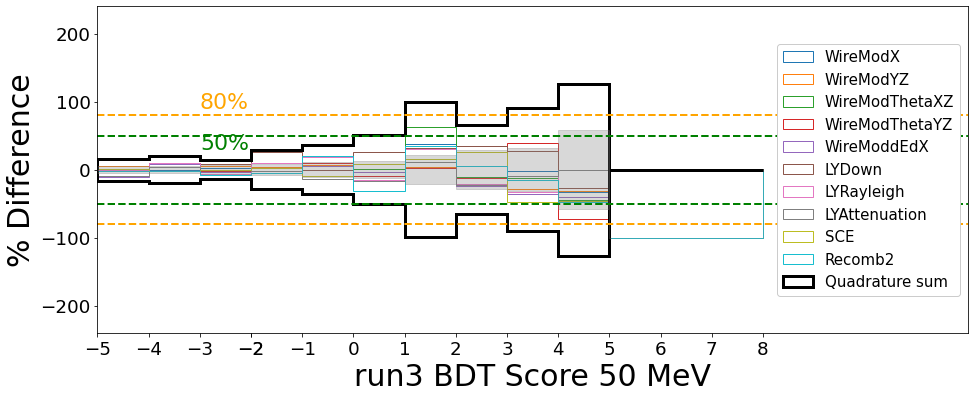

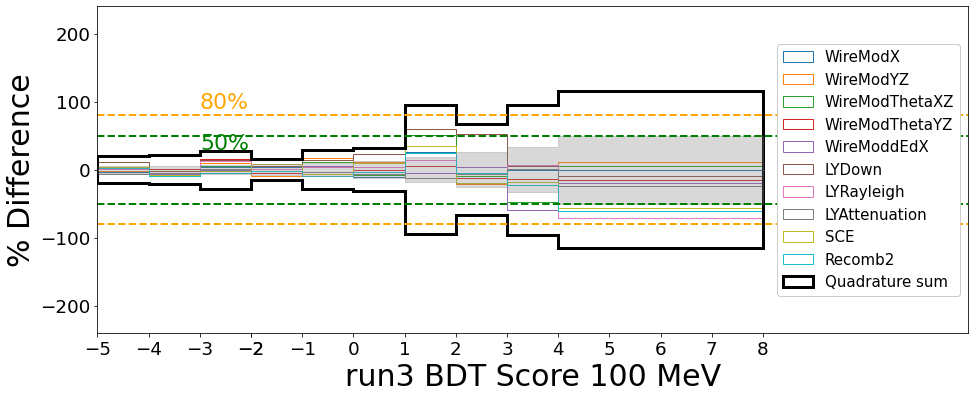

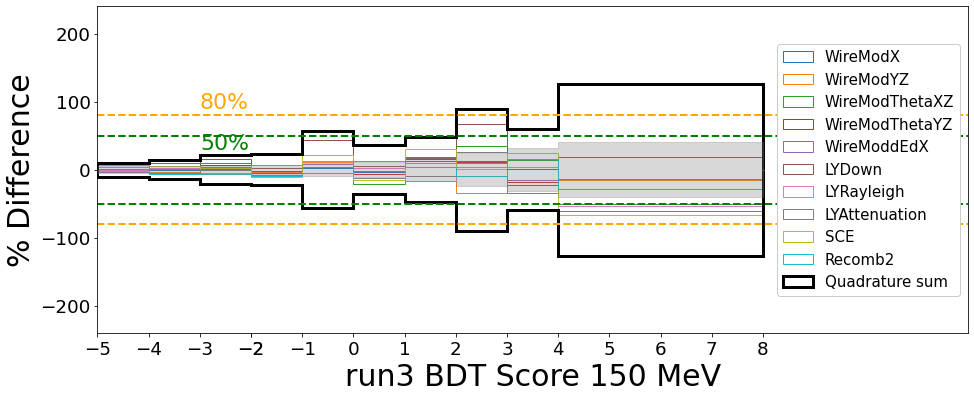

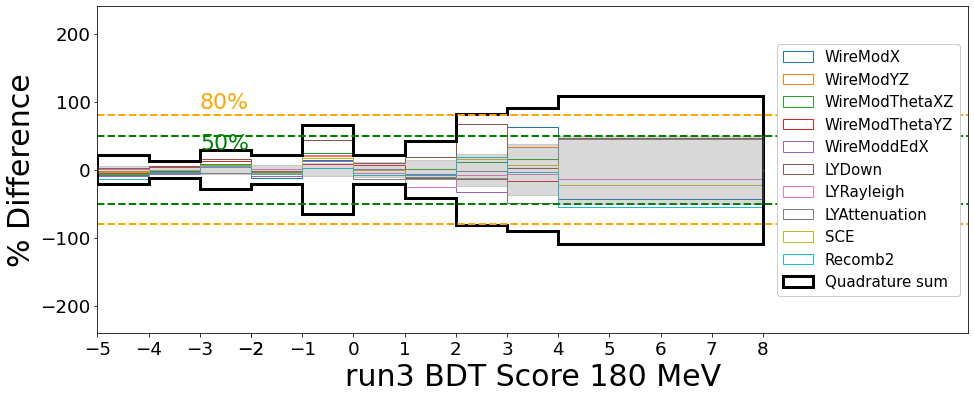

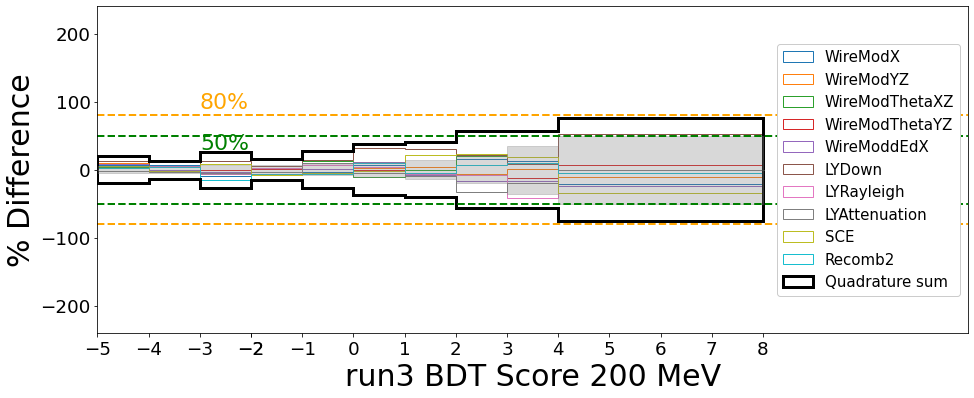

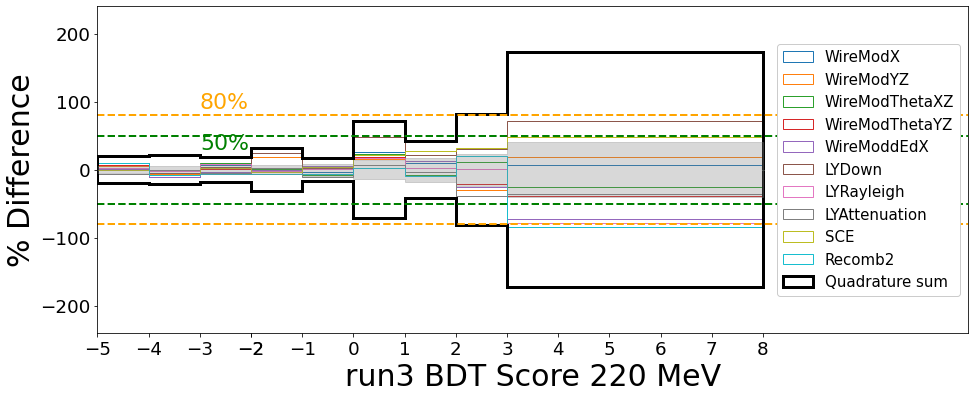

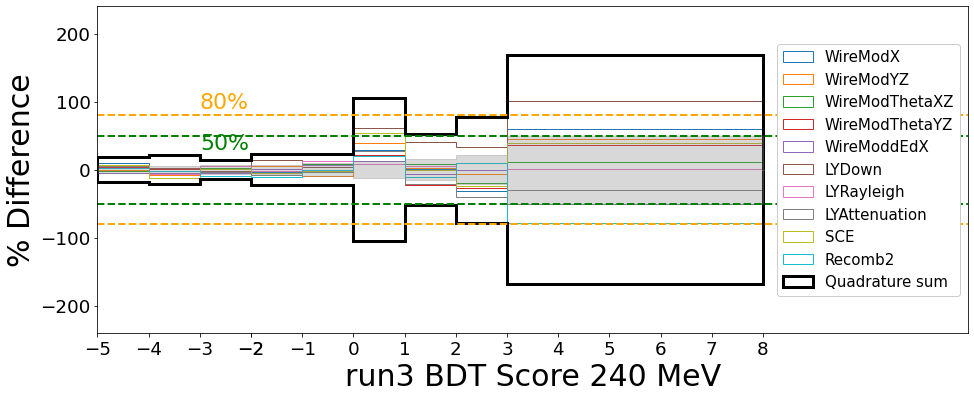

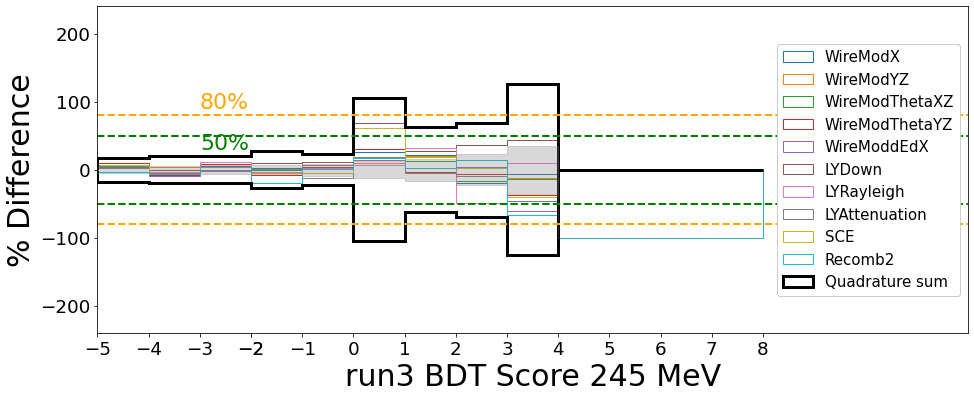

In [8]:
# Want to swap this out for the neater script below. However, below currently getting problems with zero divisors and not plotting merged bins
DetVar_percentages_dict = {}
savefig = True
display = True

figsize=(14, 6)
linewidth = 1
h_line_1 = 50 #Line displaying this % difference
h_line_2 = 80

for HNL_mass in Constants.HNL_mass_samples: #Looping over all mass points
    
    print(f"Plotting {HNL_mass}MeV histogram") 
    if Params["Use_logit"] == True:
        bins = bins_dict[HNL_mass]
        nbins = len(bins)-1
        xrange = [bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1]]
        # xlims = [-0.5, 7]
        # xticks = [0, 1, 2, 3, 4, 5]
        if Params["Run"] == "run1": 
            xlims = [-5, 11]
            xticks = [-5, -4, -3, -2, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7]
        if Params["Run"] == "run3": 
            xlims = [-5, 12]
            xticks = [-5, -4, -3, -2, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
    else:
        bins = np.linspace(0,1, 11)
        nbins = len(bins)-1
        xrange = [bins[0], bins[-1]]
        xlims = [0,1.4]
        xticks = [0, 0.2, 0.4, 0.8, 1.0]
    
    plt.figure(figsize=figsize,facecolor='white')
    RMS=np.zeros(nbins)
    frac_RMS=np.zeros(nbins)
    quad_sum=np.zeros(nbins)
    frac_quad_sum=np.zeros(nbins)
    sum_squares = np.zeros(nbins)
    stat_err = np.zeros(nbins)
    SF_on_bin = np.zeros(nbins)
    upvals = np.zeros(nbins+1)
    lowvals = np.zeros(nbins+1)
    upvals_frac = np.zeros(nbins+1)
    lowvals_frac = np.zeros(nbins+1)
    x_coords = bins_dict[HNL_mass]
    max_y = 0
    
    if Params["Use_logit"] == False:
        cv_hist, cv_bins = np.histogram(sample_test_dict["CV"][f'BDT_output_{HNL_mass}MeV'],
        range=xrange,
        bins=nbins,
        weights=sample_test_dict["CV"]["weight"])
    if Params["Use_logit"] == True:
        cv_hist, cv_bins = np.histogram(Functions.logit(sample_test_dict["CV"][f'BDT_output_{HNL_mass}MeV']),
        range=xrange,
        bins=bins,
        weights=sample_test_dict["CV"]["weight"])
    bins_cent=(cv_bins[:-1]+cv_bins[1:])/2
    for DetVar in Constants.Detector_variations:
        if DetVar == "CV":
            continue
        perc_list = []
        if Params["Use_logit"] == False:
            detvar_hist, bins = np.histogram(sample_test_dict[DetVar][f'BDT_output_{HNL_mass}MeV'],
            range=xrange,
            bins=nbins,
            weights=sample_test_dict[DetVar]["weight"])
        if Params["Use_logit"] == True:
            detvar_hist, bins = np.histogram(Functions.logit(sample_test_dict[DetVar][f'BDT_output_{HNL_mass}MeV']),
            range=xrange,
            bins=bins,
            weights=sample_test_dict[DetVar]["weight"])
        for i in range(len(detvar_hist)):
            frac = safe_div(detvar_hist[i],cv_hist[i])
            frac_diff = frac - 1.0
            perc_list.append(frac_diff*100)
        
        DetVar_percentages_dict[DetVar] = perc_list
        plt.hist(bins_cent,weights=DetVar_percentages_dict[DetVar], bins=bins,range=xrange,label=f'{DetVar}',
                lw=linewidth,histtype="step") #just 1 entry for each bin, then "weight" becomes what the percentage is (hacky way, could do something nicer)
        
    cv_no_weighting = np.histogram(Functions.logit(sample_test_dict["CV"][f'BDT_output_{HNL_mass}MeV']),
        range=xrange,
        bins=bins)[0]
    
    for j in range(len(cv_hist)):
        for DetVar in Constants.Detector_variations:
            if DetVar == "CV":
                continue
            if Params["Use_logit"] == False:
                hist_input = sample_test_dict[DetVar][f'BDT_output_{HNL_mass}MeV']
            if Params["Use_logit"] == True:
                hist_input = Functions.logit(sample_test_dict[DetVar][f'BDT_output_{HNL_mass}MeV'])
                    
            detvar_hist, bins = np.histogram(hist_input,
                                             range=xrange, 
                                             bins=bins, 
                                             weights=sample_test_dict[DetVar]["weight"])
            
            diff = cv_hist[j] - detvar_hist[j]
            diff_squared = diff**2
            sum_squares[j] = sum_squares[j]+diff_squared
            
            # SF_on_bin[j] = cv_hist[j]/cv_no_weighting[j] #This effective scale factor comes in by weighting on events
            SF_on_bin[j] = safe_div(cv_hist[j],cv_no_weighting[j])
            stat_err[j] = np.sqrt(cv_no_weighting[j])*SF_on_bin[j]
            upvals[j] = cv_hist[j]+stat_err[j]
            lowvals[j] = cv_hist[j]-stat_err[j]
            upvals_frac[j] = safe_div(upvals[j],cv_hist[j])*100-100
            lowvals_frac[j] = safe_div(lowvals[j],cv_hist[j])*100-100
        
        RMS[j] = np.sqrt(sum_squares[j]/(len(Constants.Detector_variations)-1))
        frac_RMS[j] = safe_div(RMS[j],cv_hist[j])
        quad_sum[j] = np.sqrt(sum_squares[j])
        frac_quad_sum[j] = safe_div(quad_sum[j],cv_hist[j])#quad_sum[j]/cv_hist[j]
    # max_y = max(frac_quad_sum)
    max_y = 2
    
    # print(max_y)
    ylims = [max_y*(-1.2)*100, max_y*(1.2)*100]
    plt.hist(bins_cent, weights=frac_quad_sum*100, bins=bins,range=xrange,label=f'Quadrature sum',lw=linewidth+2,
             histtype="step", color="black")
    plt.hist(bins_cent, weights=frac_quad_sum*(-100), bins=bins,range=xrange,lw=linewidth+2,
             histtype="step", color="black")
    
    # plt.hist(bins_cent, weights=frac_RMS*100, bins=bins,range=xrange,label=f'RMS',lw=linewidth+2,
    #          histtype="step", color="black")
    # plt.hist(bins_cent, weights=frac_RMS*(-100), bins=bins,range=xrange,lw=linewidth+2,
    #          histtype="step", color="black")
    
    if Params["Use_logit"] == True:plt.fill_between(x_coords, lowvals_frac, upvals_frac, step="post",color="grey",alpha=0.3,zorder=2)
    
    plt.legend(loc='center right',frameon=True, framealpha=1.0)
    plt.ylim(ylims)
    plt.xlim(xlims) #Goes up to 7 to leave space for the legend
    # plt.xlim([-5, 9]) #Goes up to 7 to leave space for the legend
    plt.xlabel(Params["Run"] + f' BDT Score {HNL_mass} MeV', fontsize=30)
    plt.ylabel('% Difference', fontsize=30)
    
    if max_y*100 > h_line_1:
        plt.axhline(y=h_line_1, lw=2, color='green', linestyle = 'dashed')
        plt.axhline(y=-1*(h_line_1), lw=2, color='green', linestyle = 'dashed')
        plt.text(-3, 30, "50%", color='green')
    
    if max_y*100 > h_line_2:
        plt.axhline(y=h_line_2, lw=2, color='orange', linestyle = 'dashed')
        plt.axhline(y=-1*(h_line_2), lw=2, color='orange', linestyle = 'dashed')
        plt.text(-3, 90, "80%", color='orange')
    
    plt.xticks(xticks) #Only keeping values for BDT scores which are possible.
    # plt.xticks([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]) #Only keeping values for BDT scores which are possible.
    #plt.yscale()
    plt.tight_layout()
    if savefig == True:
        plt.savefig("plots/Sys_uncertainty/Overlay/DetVar/bkg_DetVars_" + Params["Run"] + "_" + str(HNL_mass) + "MeV_Qaudsum_zoomed.pdf")
        plt.savefig("plots/Sys_uncertainty/Overlay/DetVar/bkg_DetVars_" + Params["Run"] + "_" + str(HNL_mass) + "MeV_Qaudsum_zoomed.png")
    if display == False:
            plt.close()

## Printing specific bin numbers

In [10]:
HNL_mass_list = [2, 10, 20, 50, 220]
for HNL_mass in HNL_mass_list:
    print(f"{HNL_mass}MeV")
    bins = bins_dict[HNL_mass]
    nbins = len(bins)-1
    xrange = [bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1]]
    print(np.histogram(Functions.logit(sample_test_dict["CV"][f'BDT_output_{HNL_mass}MeV']),range=xrange,bins=bins,weights=sample_test_dict["CV"]["weight"])[0])
    print(np.histogram(Functions.logit(sample_test_dict["CV"][f'BDT_output_{HNL_mass}MeV']),range=xrange,bins=bins)[0]) #unweighted

2MeV
[1132.8804     811.437      480.91895    290.24023    144.08838
   56.62549     29.984863    20.99121      8.998047     1.7319336]
[1207  852  510  298  148   70   37   23    8    2]
10MeV
[7.9898755e+02 6.3387500e+02 4.3842480e+02 2.6451074e+02 1.5646826e+02
 7.0047363e+01 3.2181641e+01 1.2052734e+01 1.3552734e+01 3.1738281e-01]
[895 673 462 270 156  79  35  16  10   1]
20MeV
[8.9348560e+02 7.7129932e+02 4.2959180e+02 3.1223340e+02 1.4674219e+02
 6.3001953e+01 2.7712891e+01 2.3045410e+01 1.1103027e+01 3.9355469e-01]
[1008  797  452  313  163   69   34   24   10    1]
50MeV
[947.0818   627.83984  491.0835   272.63428  131.88379   87.944336
  40.23291   19.426758   8.053711   1.640625]
[1004  674  509  297  144   91   44   23    8    3]
220MeV
[962.1245   673.89014  574.6748   332.84033  228.3457   108.427246
  63.34961   40.441406   3.194336]
[1031  717  586  355  243  123   58   27    2]


In [6]:
flat_overlay_detvar = 0.5 #The fraction of overlay detector variation error
flat_signal_detvar = 0.15 #The fraction of signal detector variation error
overlay_detvar_dict, overlay_detvar_frac_dict = {}, {}
signal_detvar_dict, signal_detvar_frac_dict = {}, {}

loc_hists = "Uncertainties/"

for HNL_mass in Constants.HNL_mass_samples:
    with uproot.open(loc_hists+f'{Params["Run"]}_{HNL_mass}MeV_logit_top_20_merged_FIXED.root') as file:
        bkg_vals_placeholder=file['bkg_overlay'].values()
        signal_vals_placeholder=file['signal'].values()
    overlay_detvar_dict[HNL_mass] = bkg_vals_placeholder*flat_overlay_detvar
    signal_detvar_dict[HNL_mass] = signal_vals_placeholder*flat_signal_detvar
    overlay_detvar_frac_dict[HNL_mass] = np.ones_like(bkg_vals_placeholder)*flat_overlay_detvar
    signal_detvar_frac_dict[HNL_mass] = np.ones_like(signal_vals_placeholder)*flat_signal_detvar

## Saving .root files with DetVar uncertainties

In [7]:
loc_hists = "Uncertainties/"

for HNL_mass in Constants.HNL_mass_samples:
    bins_cent=(bins_dict[HNL_mass][:-1]+bins_dict[HNL_mass][1:])/2

    values_dict = {'overlay_DetVar_uncertainty': overlay_detvar_dict[HNL_mass], 
                   'overlay_DetVar_uncertainty_frac': overlay_detvar_frac_dict[HNL_mass], 
                   'signal_DetVar_uncertainty':signal_detvar_dict[HNL_mass],
                   'signal_DetVar_uncertainty_frac':signal_detvar_frac_dict[HNL_mass]} 
    hist_samples = {}

    #make array with all values 1, then weight by value
    for name in values_dict:
        test_hist = np.histogram(bins_cent, weights=values_dict[name], bins=bins_dict[HNL_mass], 
                                 range=[bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1]])
        hist_samples[name] = test_hist

    stop_writing = False
    dont_save = []
    with uproot.open(loc_hists+Params["Run"]+f'_{HNL_mass}MeV_logit_top_20_merged_FIXED.root') as file: #Check what is already in the file (read-only)
        for name in hist_samples:
            if str(name)+";1" in file.keys():
                # print(str(name) + f" ALREADY EXISTS in {HNL_mass}MeV file, not re-saving")
                dont_save.append(name)
                # stop_writing = True
                # break

    with uproot.update(loc_hists+Params["Run"]+f'_{HNL_mass}MeV_logit_top_20_merged_FIXED.root') as file: #Add new hists into the file
        # del file['ppfx_uncertainty']

        for name in hist_samples:
            # if stop_writing == True:
            #     print("Not saving hist")
            #     break
            if name in dont_save:
                print(f"Not saving {name}")
            else:
                file[name] = hist_samples[name]

In [ ]:
#Making the histograms
hist_dict = {}
no_cv_hist_dict = {}
unweighted_CV_hist_dict = {}
bins_cent_dict = {}
for HNL_mass in Constants.HNL_mass_samples:
    detvar_hist_dict = {}
    bins = bins_dict[HNL_mass]
    nbins = len(bins)-1
    xrange = [bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1]]
    
    unweighted_CV_hist_dict[HNL_mass] = np.histogram(Functions.logit(sample_test_dict["CV"][f'BDT_output_{HNL_mass}MeV']),
        range=xrange,
        bins=nbins)[0]
    bins_cent_dict[HNL_mass]=(bins[:-1]+bins[1:])/2
    for DetVar in Constants.Detector_variations:
        detvar_hist_dict[DetVar] = np.histogram(Functions.logit(sample_test_dict[DetVar][f'BDT_output_{HNL_mass}MeV']),
        range=xrange,
        bins=nbins,
        weights=sample_test_dict[DetVar]["weight"])[0]
    hist_dict[HNL_mass] =  detvar_hist_dict   
    detvar_no_cv_dict = {key: val for key,
                         val in detvar_hist_dict.items() if key != 'CV'}
    no_cv_hist_dict[HNL_mass] = detvar_no_cv_dict
print("Created all detector variation hists")

In [ ]:
unweighted_CV_hist_dict[220]

Plotting 2MeV histogram
Plotting 10MeV histogram
Plotting 20MeV histogram
Plotting 50MeV histogram
Plotting 100MeV histogram
Plotting 150MeV histogram
Plotting 180MeV histogram
Plotting 200MeV histogram
Plotting 220MeV histogram
Plotting 240MeV histogram
Plotting 245MeV histogram


/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


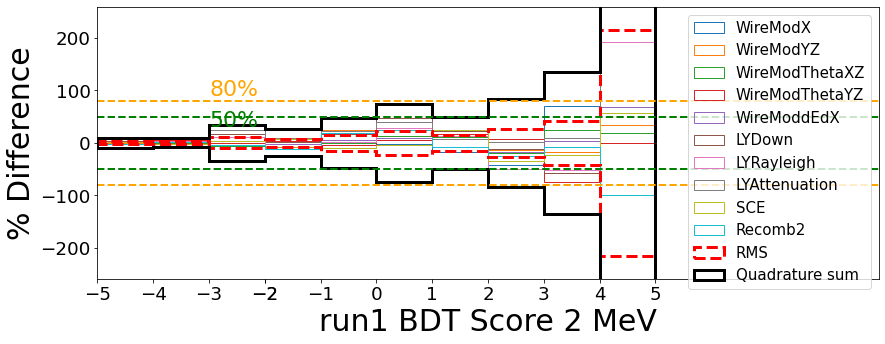

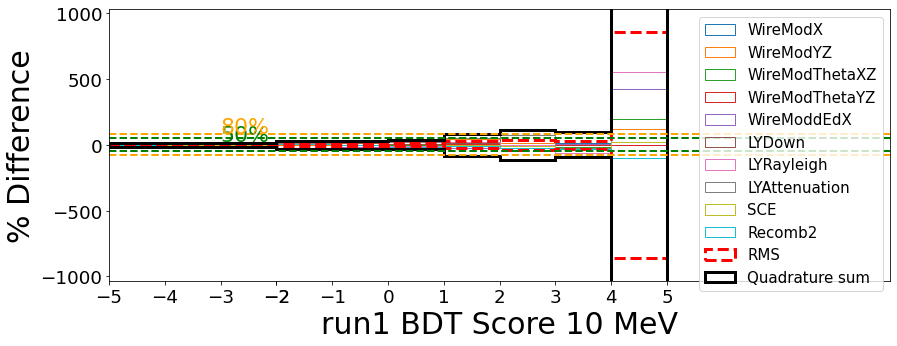

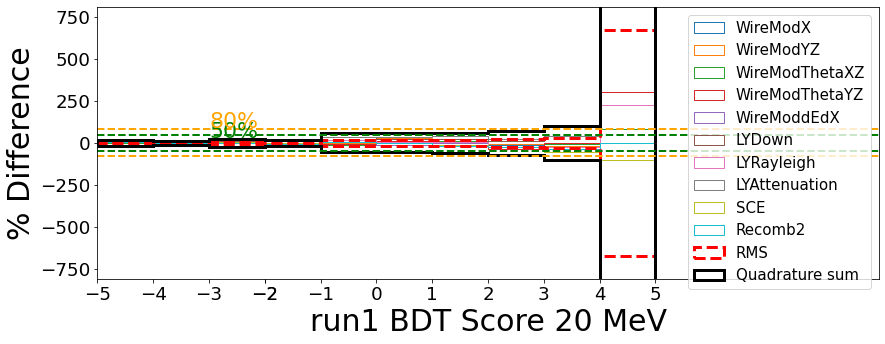

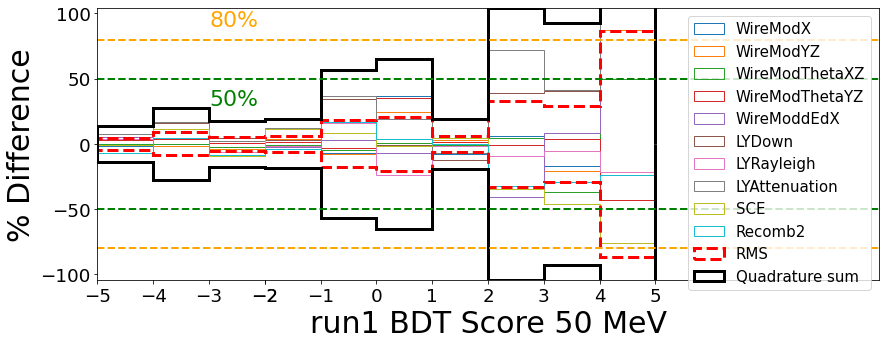

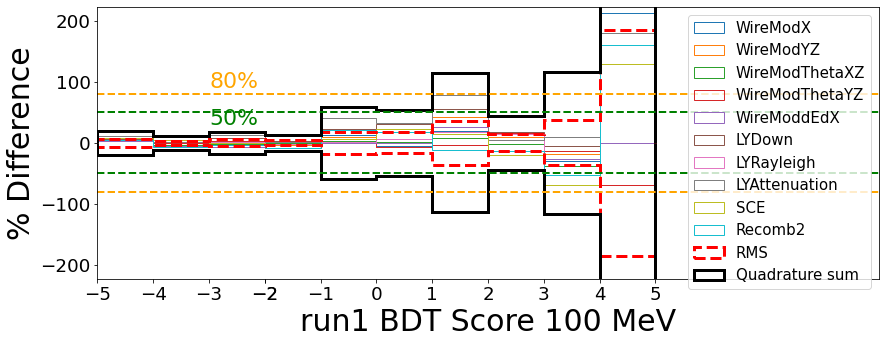

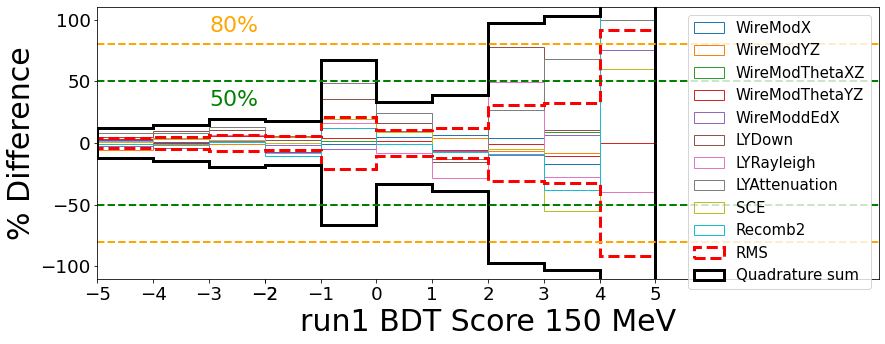

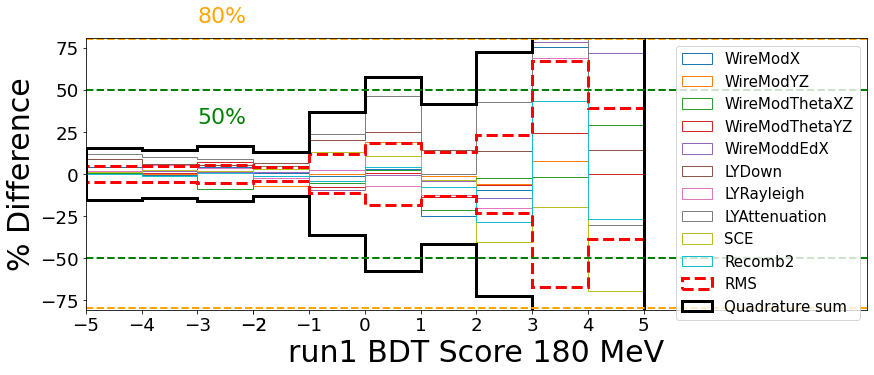

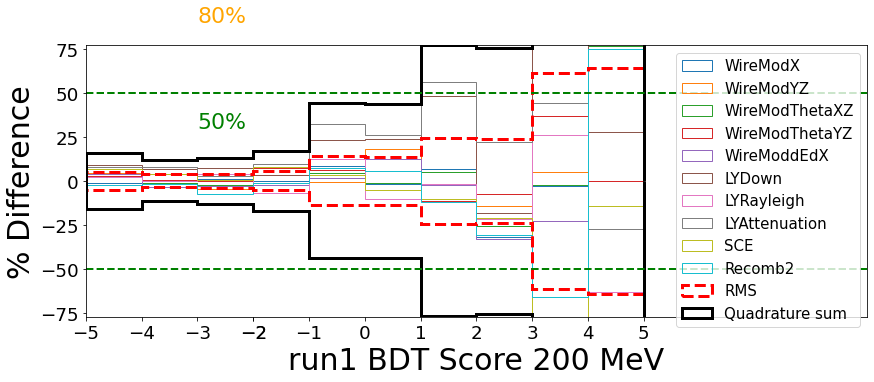

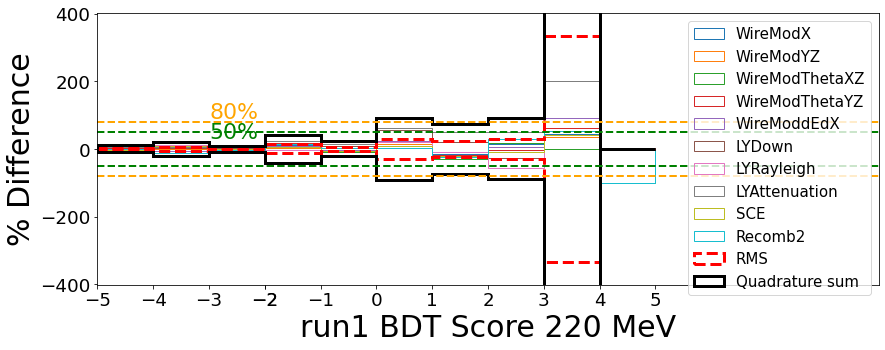

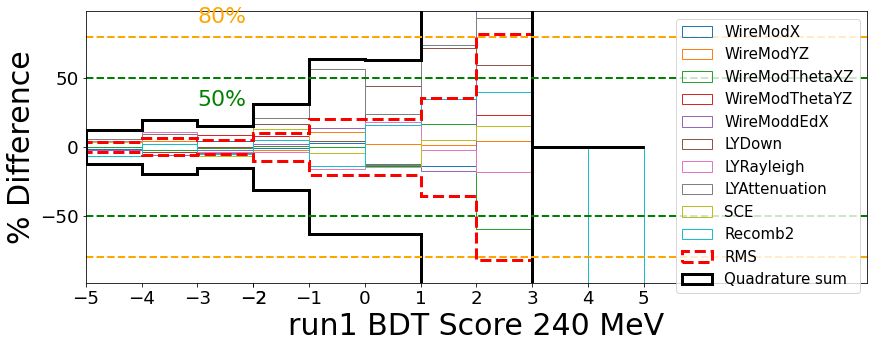

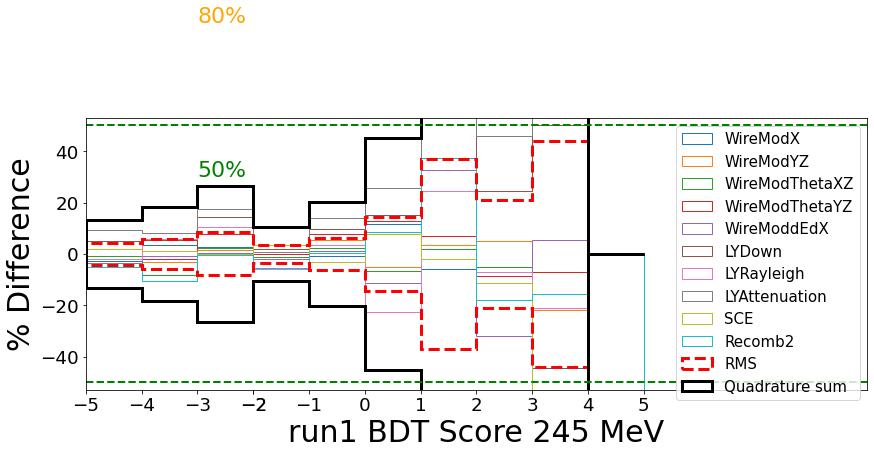

In [50]:
savefig = False
display = True

figsize=(14, 5)
linewidth = 1
h_line_1 = 50 #Line displaying this % difference
h_line_2 = 80

xlims = [-5, 9]
xticks = [-5, -4, -3, -2, -2, -1, 0, 1, 2, 3, 4, 5]

for HNL_mass in Constants.HNL_mass_samples: #Looping over all mass points
    print(f"Plotting {HNL_mass}MeV histogram") 
    plt.figure(figsize=figsize,facecolor='white')
    frac_diff_dict, perc_diff_dict = Calc_frac_diff(hist_dict[HNL_mass]["CV"], no_cv_hist_dict[HNL_mass])
    Calcs = Calc_RMS_quadsum(hist_dict[HNL_mass]["CV"], no_cv_hist_dict[HNL_mass])
    RMS, quadsum, RMS_frac, quadsum_frac = Calcs["RMS"], Calcs["quadsum"], Calcs["RMS_frac"], Calcs["quadsum_frac"]
    quadsum = Calc_RMS_quadsum(hist_dict[HNL_mass]["CV"], no_cv_hist_dict[HNL_mass])["quadsum"]
    stat_err = Calc_stat_err(hist_dict[HNL_mass]["CV"], unweighted_CV_hist_dict[HNL_mass])
    x_coords = bins_dict[HNL_mass]
    for DetVar in Constants.Detector_variations:
        if DetVar == "CV":
            continue
        else:
            plt.hist(bins_cent_dict[HNL_mass],weights=perc_diff_dict[DetVar], bins=bins,range=[bins[0],bins[-1]],label=f'{DetVar}',
                     lw=linewidth,histtype="step")
    
    # frac_RMS = np.divide(RMS,hist_dict[HNL_mass]["CV"]) #Can't do this because of zero divisor occuring
    # frac_quadsum = np.divide(quadsum,hist_dict[HNL_mass]["CV"])
    
    max_y = max(RMS_frac)
    ylims = [max_y*(-1.2)*100, max_y*(1.2)*100]
    plt.hist(bins_cent_dict[HNL_mass], weights=RMS_frac*100, bins=bins,range=xrange,label=f'RMS',lw=linewidth+2,
             histtype="step", color="red", linestyle = 'dashed')
    plt.hist(bins_cent_dict[HNL_mass], weights=RMS_frac*(-100), bins=bins,range=xrange,lw=linewidth+2,
             histtype="step", color="red", linestyle = 'dashed')
    plt.hist(bins_cent_dict[HNL_mass], weights=quadsum_frac*100, bins=bins,range=xrange,label=f'Quadrature sum',lw=linewidth+2,
             histtype="step", color="black")
    plt.hist(bins_cent_dict[HNL_mass], weights=quadsum_frac*(-100), bins=bins,range=xrange,lw=linewidth+2,
             histtype="step", color="black")

    # plt.fill_between(x_coords, lowvals_frac, upvals_frac, step="post",color="grey",alpha=0.3,zorder=2)
    
    plt.legend(loc='upper right',frameon=True)
    plt.ylim(ylims)
    plt.xlim(xlims) #Goes up to 7 to leave space for the legend
    # plt.xlim([-5, 9]) #Goes up to 7 to leave space for the legend
    plt.xlabel(Params["Run"] + f' BDT Score {HNL_mass} MeV', fontsize=30)
    plt.ylabel('% Difference', fontsize=30)
    
    plt.axhline(y=h_line_1, lw=2, color='green', linestyle = 'dashed')
    plt.axhline(y=-1*(h_line_1), lw=2, color='green', linestyle = 'dashed')
    plt.text(-3, 30, "50%", color='green')
    
    plt.axhline(y=h_line_2, lw=2, color='orange', linestyle = 'dashed')
    plt.axhline(y=-1*(h_line_2), lw=2, color='orange', linestyle = 'dashed')
    plt.text(-3, 90, "80%", color='orange')
    
    plt.xticks(xticks)
    
    if savefig == True:
        plt.savefig("plots/Sys_uncertainty/Overlay/DetVar/" + Params["Run"] + "_" + str(HNL_mass) + "_MeV_DetVars_lines.png")
    if display == False:
        plt.close()

In [ ]:
#Plotting the histograms for detector variations
HNL_mass = 200 # - Plot just one
if Params["Load_DetVars"] == True:
    for DetVar in Constants.Detector_variations:
        linewidth = 1
        if DetVar == "CV":
            linewidth = 3
        if Params["Use_logit"] == False:
            plt.hist(sample_test_dict[DetVar][f'BDT_output_{HNL_mass}MeV'], weights=sample_test_dict[DetVar]["weight"], 
                     bins=Params["nbins"],range=[0,1.0],label=f'{DetVar}',lw=linewidth,histtype="step")
        if Params["Use_logit"] == True:
            plt.hist(Functions.logit(sample_test_dict[DetVar][f'BDT_output_{HNL_mass}MeV']), weights=sample_test_dict[DetVar]["weight"], 
                     bins=5,range=[0.0,5.0],label=f'{DetVar}',lw=linewidth,histtype="step")
            
    plt.xlabel(f'BDT_output_{HNL_mass}MeV')
    #plt.legend()
    #plt.yscale("log")
    plt.yscale("linear")
    # plt.ylim(1, maxium*1.3)